# Mount the google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Install the required libraries

In [3]:
import numpy as np
import cv2
from pathlib import Path
#from google.colab.patches import cv2_imshow
import pickle

from shapely.geometry import box
from shapely.geometry import Polygon as shapely_poly
from IPython.display import clear_output, Image, display, HTML
import io
import base64
%matplotlib inline
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [3]:
!pip install opencv-python

In [2]:
!pip install shapely

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 1.4/1.4 MB 6.2 MB/s eta 0:00:00


In [6]:
!pip install matplotlib

  Using cached matplotlib-3.5.3-cp37-cp37m-win_amd64.whl (7.2 MB)
  Using cached kiwisolver-1.4.4-cp37-cp37m-win_amd64.whl (54 kB)
  Using cached Pillow-9.5.0-cp37-cp37m-win_amd64.whl (2.5 MB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)


In [2]:
!pip install q keras==2.1.0.

In [ ]:
cd /content/gdrive/My Drive

/content/gdrive/My Drive


# Preprocessing and removing files whose XML dont have a key 

In [4]:
import os
from xml.etree import ElementTree
directory = 'C:/Users/Leena Ali/Documents/DataScienceProjects/Smart-Parking-System-master/Code/Colab Notebooks/Data/Train/Labels'

for filename in os.listdir(directory):
  if filename.endswith(".xml"):
    #print(os.path.join(directory, filename))
    
    tree = ElementTree.parse(os.path.join(directory, filename))
    root = tree.getroot()
    for space in root.iter('space'):
      try:
        cls_id = int(space.attrib['occupied'])
      except:
        print(filename)

# Clone in Matterpot implemented Mask-RCNN repository

In [3]:
!git clone https://github.com/matterport/Mask_RCNN

In [5]:
import os
os.chdir("Mask_RCNN/")

In [6]:



import mrcnn.config
import mrcnn.utils
from mrcnn.model import MaskRCNN

Using TensorFlow backend.


In [12]:
!pip install --user protobuf==3.20

In [ ]:
!pip uninstall scikit-image

In [7]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

# Define Class for Parking Lot for PKLot Dataset

In [8]:
class ParkingLot(Dataset):

    def load_dataset(self, dataset_dir, is_train=True): 
        self.add_class('parking', 1,'ParkingOccupied')
        self.add_class('parking', 2,'ParkingEmpty')
        if is_train:
            img_dir = os.path.join(dataset_dir, 'Train/Images')
            labels_dir = os.path.join(dataset_dir, 'Train/Labels')
        elif not is_train:
            img_dir = os.path.join(dataset_dir, 'Test/Images')
            labels_dir = os.path.join(dataset_dir, 'Test/Labels')
        for filename in os.listdir(img_dir):
            image_id = filename[:-4]
            img_path = os.path.join(img_dir, filename)
            label_path = labels_dir + '/' + image_id + '.xml'
            self.add_image('parking', image_id=image_id,path=img_path, annotation=label_path) 

    def extract_contours(self, filename):
        tree = ElementTree.parse(filename)
        root = tree.getroot()
        contours = []
        for space in root.getiterator('space'):
          cls_id = int(space.attrib['occupied'])
          for rect in space.findall('rotatedRect/center'):
              x = int(rect.get('x')) 
              y = int(rect.get('y')) 
          for rect in space.findall('rotatedRect/size'):
              w = int(rect.get('w'))
              h = int(rect.get('h'))
          for rect in space.findall('rotatedRect/angle'):
              d = int(rect.get('d'))
          coors = [cls_id, x, y, w, h, d] 
          contours.append(coors)
        return contours            

    def load_mask(self, image_id):
        info = self.image_info[image_id] 
        path = info['annotation'] 
        contours = self.extract_contours(path) 
        mask = np.zeros([720, 1280, len(contours)], dtype  = 'uint8')
        class_ids = []
        for i in range (len(contours)):
            contour = contours[i] 
            cls_id, x, y, w, h, d = contour 
            row_s, row_e = y-(w), y+(w//2)
            col_s, col_e = x-(h//2), x+(h//2) 
            mask[row_s:row_e, col_s:col_e, i] = 1
            if cls_id==1:
                class_ids.append(self.class_names.index('ParkingOccupied'))   
            elif cls_id==0:
                 class_ids.append(self.class_names.index('ParkingEmpty'))
        return mask, np.asarray(class_ids, dtype='int32') 

    def image_ref(self, image_id):
        info = self.image_info[image_id]
        return info['path']  


# Configure the Training Pipeline

## Parking Config

In [9]:
class ParkingConfig(mrcnn.config.Config):
    NAME = 'parking_cfg'
    NUM_CLASSES = 1+2
    STEPS_PER_EPOCH = 833
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

train_set = ParkingLot()
train_set.load_dataset('C:/Users/Leena Ali/Documents/DataScienceProjects/Smart-Parking-System-master/Code/Colab Notebooks/Data', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
test_set = ParkingLot()
test_set.load_dataset('C:/Users/Leena Ali/Documents/DataScienceProjects/Smart-Parking-System-master/Code/Colab Notebooks/Data', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids)) 
config = ParkingConfig()
config.display()  

Train: 825
Test: 136

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 1

## Set path for Model & COCO pretrained Model

In [10]:
ROOT_DIR = Path(".")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [11]:
if not os.path.exists(COCO_MODEL_PATH):
    mrcnn.utils.download_trained_weights(COCO_MODEL_PATH)

## Using Transfer Learning, train the model on PKLot Dataset

model.train(..., layers='heads', ...)  # Train heads branches (least memory)

model.train(..., layers='3+', ...)     # Train resnet stage 3 and up

model.train(..., layers='4+', ...)     # Train resnet stage 4 and up

model.train(..., layers='all', ...)    # Train all layers (most memory)

In [12]:
model =  MaskRCNN(mode='training', model_dir= MODEL_DIR, config = config)
model.load_weights(COCO_MODEL_PATH, by_name = True, exclude = ["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
model.train(train_set, test_set, learning_rate = config.LEARNING_RATE, epochs=5, layers = 'heads')  







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead

Starting at epoch 0. LR=0.001

Checkpoint Path: .\logs\parking_cfg20230418T0931\mask_rcnn_parking_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_ma

C:\Users\Leena Ali\anaconda3\envs\tensor1\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Leena Ali\anaconda3\envs\tensor1\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Leena Ali\anaconda3\envs\tensor1\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "












Epoch 1/5
833/833 [==============================] - 18388s 22s/step - loss: 3.2409 - rpn_class_loss: 0.4570 - rpn_bbox_loss: 1.4326 - mrcnn_class_loss: 0.3749 - mrcnn_bbox_loss: 0.9120 - mrcnn_mask_loss: 0.0644 - val_loss: 1.0852 - val_rpn_class_loss: 0.1245 - val_rpn_bbox_loss: 0.1930 - val_mrcnn_class_loss: 0.4529 - val_mrcnn_bbox_loss: 0.3124 - val_mrcnn_mask_loss: 0.0024

Epoch 2/5
833/833 [==============================] - 22259s 27s/step - loss: 0.8863 - rpn_class_loss: 0.1154 - rpn_bbox_loss: 0.1944 - mrcnn_class_loss: 0.3122 - mrcnn_bbox_loss: 0.2626 - mrcnn_mask_loss: 0.0019 - val_loss: 0.6134 - val_rpn_class_loss: 0.0589 - val_rpn_bbox_loss: 0.1236 - val_mrcnn_class_loss: 0.2647 - val_mrcnn_bbox_loss: 0.1646 - val_mrcnn_mask_loss: 0.0017
Epoch 3/5
833/833 [==============================] - 16872s 20s/step - loss: 0.6342 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1816 - mrcnn_mask_loss: 8.0407e-04 - val_loss: 0.4

In [1]:
!pip install scipy==1.2.2

     -                                        1.0/30.0 MB 3.9 MB/s eta 0:00:08


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Leena Ali\anaconda3\envs\tensor1\lib\site-packages\pip\_vendor\urllib3\response.py", line 437, in _error_catcher
    yield
  File "C:\Users\Leena Ali\anaconda3\envs\tensor1\lib\site-packages\pip\_vendor\urllib3\response.py", line 560, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "C:\Users\Leena Ali\anaconda3\envs\tensor1\lib\site-packages\pip\_vendor\urllib3\response.py", line 526, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "C:\Users\Leena Ali\anaconda3\envs\tensor1\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
  File "C:\Users\Leena Ali\anaconda3\envs\tensor1\lib\http\client.py", line 465, in read
    n = self.readinto(b)
  File "C:\Users\Leena Ali\anaconda3\envs\tensor1\lib\http\client.py", line 509, in readinto
    n = self.fp.readinto(b)
  File "C:\Users\Leena Ali\anaconda3\envs\te

# Configure the Testing Pipeline

## Prediction Config

In [13]:
class PredictionConfig(mrcnn.config.Config):
    NAME = 'parking_cfg'
    NUM_CLASSES = 1+2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

## Predict model with 'Inference' Mode, use the model trained (mask_rcnn_parking_cfg_0005.h5)

In [14]:
model_predict = MaskRCNN(mode="inference", model_dir='C:/Users/Leena Ali/Documents/DataScienceProjects/Smart-Parking-System-master/Code/GUI/web app implemenation/logs/parking_cfg20230405T1954/mask_rcnn_parking_cfg_0005.h5', config=config)
model_predict.load_weights('C:/Users/Leena Ali/Documents/DataScienceProjects/Smart-Parking-System-master/Code/GUI/web app implemenation/logs/parking_cfg20230405T1954/mask_rcnn_parking_cfg_0005.h5',by_name= True)



Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 5


# Check the prediction with sample images

## Define the boxes to be drawn for each detected parking lot

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

def draw_image_with_boxes(filename, boxes_list, class_list):
  occupied = 0
  empty = 0

  data = plt.imread(filename)
  plt.figure(figsize=(20,14))
  plt.imshow(data)

  ax = plt.gca()

  for box, cls in zip(boxes_list, class_list):
    y1, x1, y2, x2 = box
    width, height = x2 - x1, y2 - y1

    if cls==1:
      rect = mpatches.Rectangle((x1,y1),width,height,fill=False,linewidth=5, color='red')
      occupied = occupied + 1
    elif cls==2:
      rect = mpatches.Rectangle((x1,y1),width,height,fill=False,linewidth=5, color='green')
      empty = empty +1
    ax.add_patch(rect)

  #plt.savefig('/content/gdrive/My Drive/Data/detection.png',bbox_inches='tight')
  plt.show()
  print("No. of Occupied Slots:", occupied)
  print("No. of Empty Slots:", empty)

## Show the output for an given image of parking lot

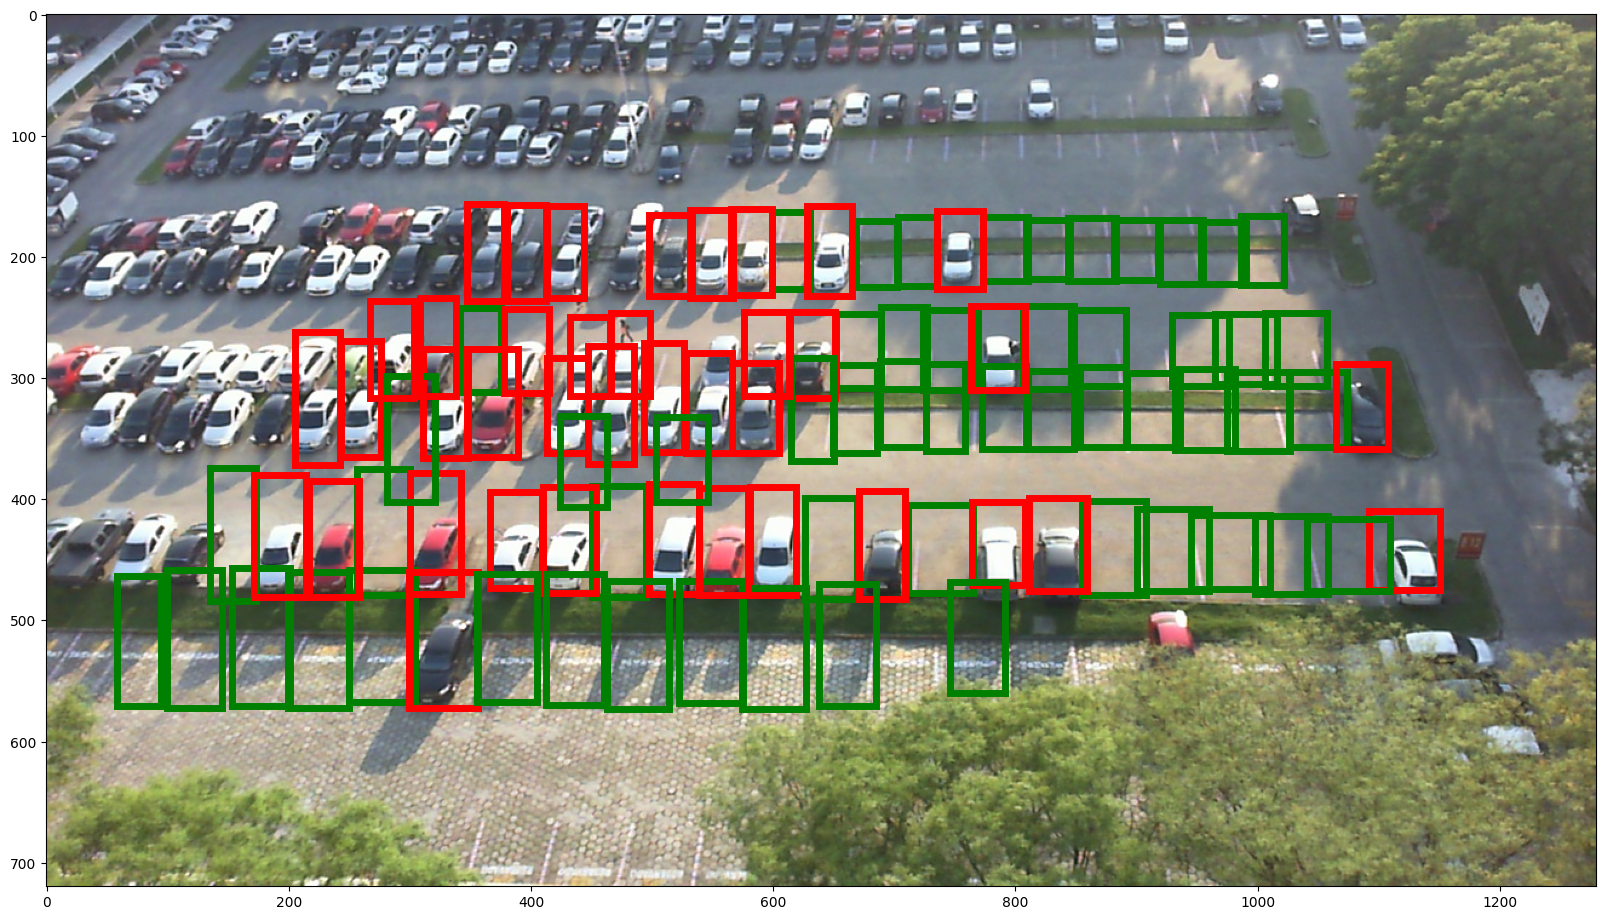

No. of Occupied Slots: 39
No. of Empty Slots: 55


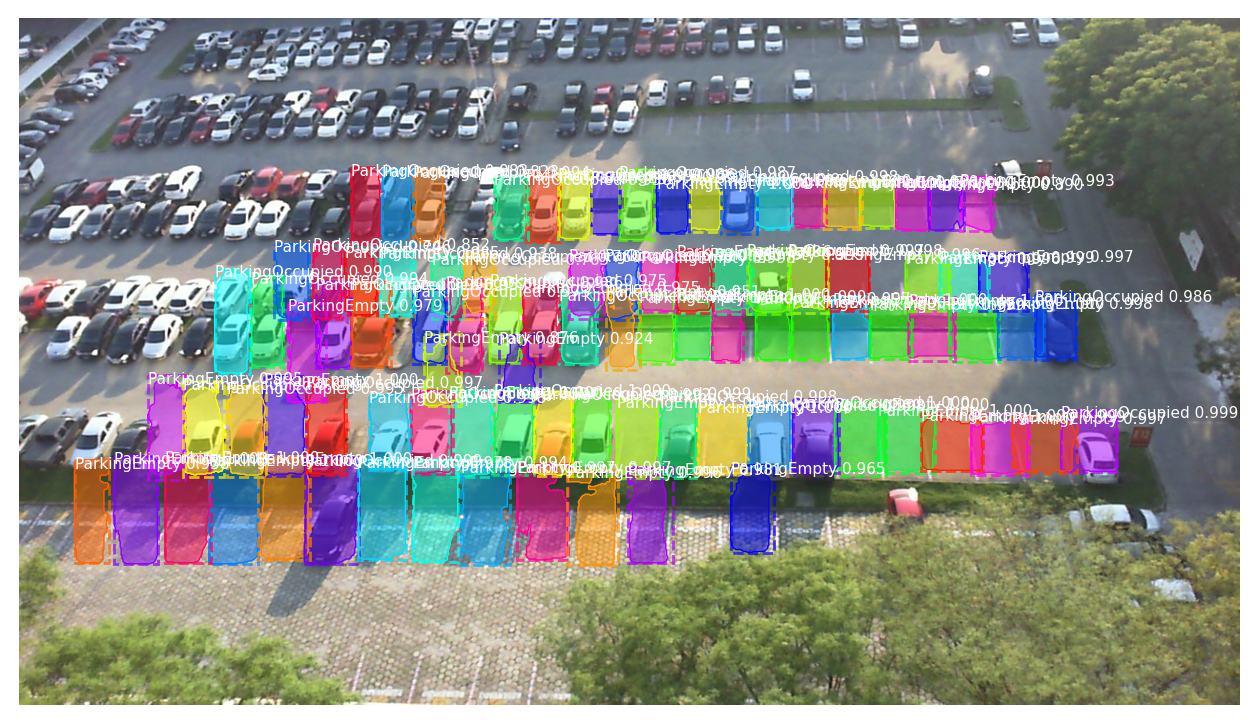

In [16]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from mrcnn.visualize import display_instances

img1 = image.load_img('C:/Users/Leena Ali/Documents/DataScienceProjects/Smart-Parking-System-master/Code/Colab Notebooks/Data/Test/Images/2012-10-31_07_38_02.jpg')
img1 = image.img_to_array(img1)

# img2 = image.load_img('/content/gdrive/My Drive/Data/Test/Images/2012-10-23_08_20_50.jpg')
# img2 = image.img_to_array(img2)
#print(len(input_img))

results = model_predict.detect([img1])

draw_image_with_boxes('C:/Users/Leena Ali/Documents/DataScienceProjects/Smart-Parking-System-master/Code/Colab Notebooks/Data/Test/Images/2012-10-31_07_38_02.jpg',results[0]['rois'],results[0]['class_ids'])
#print(results[0]['rois'],results[0]['class_ids'])
r = results[0]
class_names = ['BG', 'ParkingOccupied', 'ParkingEmpty']

display_instances(img1,r['rois'],r['masks'],r['class_ids'],class_names,r['scores'])

# Calculate mAP on the trained model

In [17]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = np.expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = np.mean(APs)
	return mAP

## Train mAP

In [18]:
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model_predict, config)
print("Train mAP: %.3f" % train_mAP)

Train mAP: 0.960


## Test mAP

In [19]:
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model_predict, config)
print("Test mAP: %.3f" % test_mAP)

Test mAP: 0.987


# Testing the model with an image of different parking lot

In [32]:
img1 = image.load_img('/content/gdrive/My Drive/Data/parking-test.jpg')
img1 = image.img_to_array(img1)


results = model_predict.detect([img1])

draw_image_with_boxes('/content/gdrive/My Drive/Data/parking-test.jpg',results[0]['rois'],results[0]['class_ids'])
#print(results[0]['rois'],results[0]['class_ids'])
r = results[0]
class_names = ['BG', 'ParkingOccupied', 'ParkingEmpty']

display_instances(img1,r['rois'],r['masks'],r['class_ids'],class_names,r['scores'])